<a href="https://colab.research.google.com/github/siduanmiao/Computational-System-Biology/blob/main/Lecture%206%20Generative%20Models%2C%20GANs%2C%20VAE/GAN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 针对GAN的训练，代码来源于其他开源项目
# Google开发了GAN可视化工具-GAN Lab，但是我认为还是需要自己写代码来熟悉pytorch下的模型搭建
# 可视化部分没有使用保存多个图片的方法，而是只保留最后一次训练的结果，日后学的精进了再来

In [16]:
# 导入所需的包
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


"""
Hyperparameter settings
"""
epochs = 15
lr = 2e-5
batch_size = 64
loss = nn.BCELoss()

In [4]:
# 分类器和生成器搭建
# 这里使用的是最简单的全连接层，尽可能减少模型错误
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [5]:
# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
# 因为我们并不需要使用标签，所以我们
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [7]:
"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
G.train()
D.train()
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128, requires_grad=True) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

Epoch 0 Iteration 100: discriminator_loss 0.615 generator_loss 0.475
Epoch 0 Iteration 200: discriminator_loss 0.673 generator_loss 0.499
Epoch 0 Iteration 300: discriminator_loss 0.692 generator_loss 0.524
Epoch 0 Iteration 400: discriminator_loss 0.687 generator_loss 0.560
Epoch 0 Iteration 500: discriminator_loss 0.668 generator_loss 0.604
Epoch 0 Iteration 600: discriminator_loss 0.672 generator_loss 0.615
Epoch 0 Iteration 700: discriminator_loss 0.675 generator_loss 0.629
Epoch 0 Iteration 800: discriminator_loss 0.641 generator_loss 0.664
Epoch 0 Iteration 900: discriminator_loss 0.692 generator_loss 0.631
Epoch 0 Iteration 938: discriminator_loss 0.654 generator_loss 0.662
Epoch 1 Iteration 100: discriminator_loss 0.681 generator_loss 0.624
Epoch 1 Iteration 200: discriminator_loss 0.660 generator_loss 0.663
Epoch 1 Iteration 300: discriminator_loss 0.634 generator_loss 0.680
Epoch 1 Iteration 400: discriminator_loss 0.647 generator_loss 0.685
Epoch 1 Iteration 500: discriminat

In [61]:
noise = (torch.rand(real_inputs.shape[0], 128, requires_grad=True) - 0.5) / 0.5
noise = noise.to(device)
noise

tensor([[ 0.3220,  0.8396,  0.4234,  ...,  0.1869, -0.8362,  0.7553],
        [ 0.1396,  0.0685,  0.2215,  ..., -0.2931, -0.7137, -0.6209],
        [ 0.1654,  0.4996,  0.7484,  ..., -0.4932, -0.4937,  0.5635],
        ...,
        [ 0.1737, -0.3674, -0.6141,  ...,  0.5370,  0.0932,  0.7052],
        [-0.4301,  0.8625,  0.3434,  ...,  0.7506, -0.6625, -0.6742],
        [ 0.0150,  0.8092, -0.3635,  ...,  0.3886, -0.5247, -0.4696]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

In [62]:
fake_inputs = G(noise)
fake_inputs

tensor([[[[-0.8006, -0.9924, -0.9942,  ..., -0.9936, -0.9928, -0.9918],
          [-0.9888, -0.9908, -0.9982,  ...,  0.4581, -0.9974, -0.9671],
          [-0.9968, -0.9117, -0.9927,  ..., -0.9922, -0.8073, -0.9675],
          ...,
          [-0.9958, -0.9938, -0.9962,  ..., -0.9972, -0.9965, -0.9947],
          [-0.9896, -0.9966, -0.9965,  ..., -0.9908, -0.9977, -0.9963],
          [-0.9652, -0.9956, -0.9972,  ..., -0.9965, -0.9972, -0.9615]]],


        [[[-0.8524, -0.9957, -0.9969,  ..., -0.9964, -0.9942, -0.9968],
          [-0.9923, -0.9954, -0.9990,  ...,  0.4868, -0.9985, -0.9848],
          [-0.9978, -0.8665, -0.9940,  ..., -0.9957, -0.8503, -0.9762],
          ...,
          [-0.9978, -0.9966, -0.9981,  ..., -0.9981, -0.9977, -0.9971],
          [-0.9937, -0.9983, -0.9984,  ..., -0.9937, -0.9980, -0.9975],
          [-0.9690, -0.9966, -0.9982,  ..., -0.9979, -0.9985, -0.9635]]],


        [[[-0.8862, -0.9979, -0.9979,  ..., -0.9984, -0.9977, -0.9979],
          [-0.9965, -0.997

In [35]:
noise.size()

torch.Size([32, 128])

In [36]:
fake_inputs.size()

torch.Size([32, 1, 28, 28])

In [66]:
image=fake_inputs.detach().cpu()
image[0].shape


torch.Size([1, 28, 28])

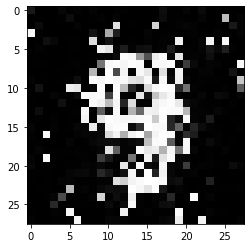

In [70]:
plt.imshow(image[0][0],cmap="gray")